In [1]:
import gymnasium as gym
import numpy
import random
import matplotlib.pyplot as plt

# Util Functions

In [2]:
def squish(array, step):
    averages = []
    n = len(array)
    
    for i in range(0, n, step):
        chunk = array[i:i + step]
        chunk_sum = sum(chunk)
        chunk_average = chunk_sum / len(chunk)
        averages.append(chunk_average)
        
    return averages

# Agent

In [3]:
class QAgent:
    def __init__(self,
                 training,
                 env,
                 learning_rate,
                 discount_factor,
                 start_exploration_prob,
                 min_exploration_prob,
                 exploration_prob_decay):
        """
        Initializes the QAgent with the given parameters and creates a Q-table filled with zeros.

        Args:
            env (gym.Env): The environment in which the agent operates.
            learning_rate (float): The learning rate (alpha).
            discount_factor (float): The discount factor (gamma).
            start_exploration_prob (float): The initial exploration probability (epsilon).
            min_exploration_prob (float): The minimum exploration probability.
            exploration_prob_decay (float): The rate at which exploration probability decays.
        """
        
        self.training = training
        self.env = env

        # Create Q-Table filled with zeros
        self.q_table = numpy.zeros((env.observation_space.n, env.action_space.n))

        # Hyperparameters
        self.learning_rate = learning_rate                  # Alpha
        self.discount_factor = discount_factor              # Gamma
        self.exploration_prob = start_exploration_prob      # Epsilon
        self.min_exploration_prob = min_exploration_prob
        self.exploration_prob_decay = exploration_prob_decay

    def get_action(self, state):
        """
        Selects an action based on an epsilon-greedy policy.

        Args:
            state (int): The current state of the environment.

        Returns:
            int: The action chosen by the agent. It will explore (random action) with a probability 
                 of self.exploration_prob, otherwise it will exploit (choose the best action based on Q-table).
        """
        if self.training and random.uniform(0, 1) < self.exploration_prob:
            return self.env.action_space.sample()
        else:
            return numpy.argmax(self.q_table[state])

    def update_q_table(self, state, action, new_state, reward):
        """
        Updates the Q-table using the Bellman equation.

        Args:
            state (int): The previous state.
            action (int): The action taken.
            new_state (int): The state after taking the action.
            reward (float): The reward received after taking the action.
        """
        alpha = self.learning_rate
        gamma = self.discount_factor

        # Bellman Equation
        value = self.q_table[state, action]
        new_state_max = numpy.max(self.q_table[new_state])
        new_value = (1 - alpha) * value + alpha * (reward + gamma * new_state_max)

        # Write to Q-Table
        self.q_table[state, action] = new_value

    def decay_exploration_prob(self):
        """
        Decays the exploration probability after each episode to reduce the rate of exploration over time.
        Ensures that the exploration probability does not fall below the minimum exploration probability.
        """
        self.exploration_prob = max(self.min_exploration_prob, self.exploration_prob - self.exploration_prob_decay)


# Training

In [4]:
# ----- Parameters -----
total_episodes = 10_000
max_episode_steps = 200

learning_rate = 0.1
discount_factor = 0.9
start_exploration_prob = 1.0
min_exploration_prob = 0.0
exploration_prob_decay = start_exploration_prob / (total_episodes / 2)



env = gym.make("Taxi-v3")
agent = QAgent(True,
                    env,
                    learning_rate,
                    discount_factor,
                    start_exploration_prob,
                    min_exploration_prob,
                    exploration_prob_decay)

reward_sum_per_episode = []
steps_per_episode = []

# Episode
for episode in range(total_episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False
    reward_sum = 0
    step = 0

    # Steps in an Episode
    while (not terminated and not truncated and step < max_episode_steps):
        action = agent.get_action(state)
        new_state, reward, terminated, truncated, _ = env.step(action)

        agent.update_q_table(state, action, new_state, reward)
        state = new_state

        reward_sum += reward
        step += 1
    
    agent.decay_exploration_prob()
    reward_sum_per_episode.append(reward_sum)
    steps_per_episode.append(step)

env.close()

([<matplotlib.lines.Line2D at 0x114532450>],
 [<matplotlib.lines.Line2D at 0x1147b4770>])

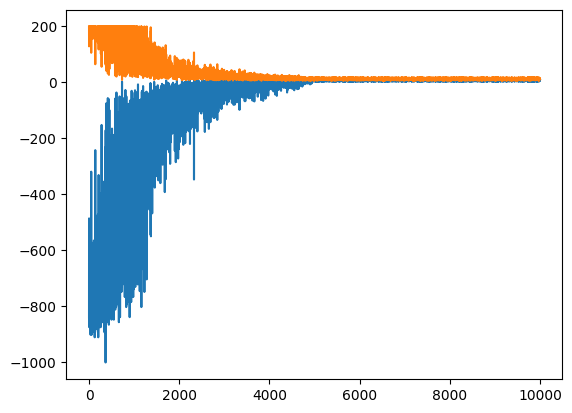

In [5]:
# Blue                            Orange
plt.plot(reward_sum_per_episode), plt.plot(steps_per_episode)

([<matplotlib.lines.Line2D at 0x1147786e0>],
 [<matplotlib.lines.Line2D at 0x117059c70>])

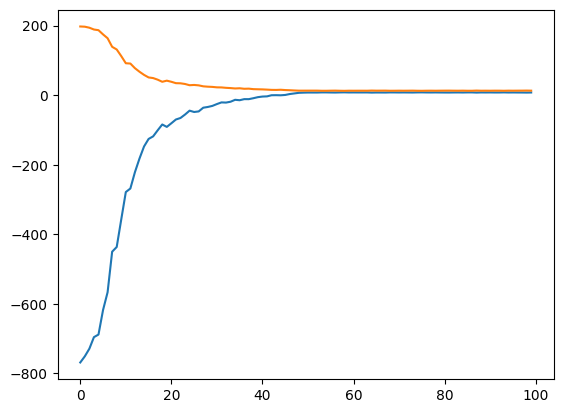

In [6]:
squished_rewards = squish(reward_sum_per_episode, 100)
squished_steps = squish(steps_per_episode, 100)

plt.plot(squished_rewards), plt.plot(squished_steps)

# Evaluate Agent

In [ ]:
env = gym.make("Taxi-v3", render_mode="human")
agent.training = False

total_episodes = 5
max_episode_steps = 200

# Episode
for episode in range(total_episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False
    reward_sum = 0
    step = 0

    # Steps in an Episode
    while (not terminated and not truncated and step < max_episode_steps):
        action = agent.get_action(state)
        new_state, reward, terminated, truncated, _ = env.step(action)

        state = new_state

        reward_sum += reward
        step += 1
    
    print(f"Reward for Episode {episode}: {reward_sum}")
    reward_sum_per_episode.append(reward_sum)
    steps_per_episode.append(step)

env.close()